# Toy example : Parameter estimation with $Ma(q)$

## Definition of the model
$$x_{t}=\mu+\epsilon_{t}-\sum_{i=1}^{q} \vartheta_{i} \epsilon_{t-i}$$

In [1]:
import numpy as np

def MAq(t, n_obs=10000, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    s = t.shape[1]
    assert t.shape[0] == batch_size
    random_state = random_state or np.random
    w = random_state.randn(batch_size, n_obs+s)  # i.i.d. sequence ~ N(0,1)
    x = w[:, s:]
    for p in range(s):
        x = x + np.repeat(np.reshape(t[:, p], (batch_size, 1)),
                          n_obs, axis=1)*w[:, (s-p-1):(-p-1)]
    return x

## Priors constraint

For identifiability reasons, 

$$\mathcal{Q}(u)=1-\sum_{i=1}^{q} \vartheta_{i} u^{i}$$

should have only roots outside of the (complex) unity disc.

In [2]:
import math

def generate_maq_priors(q, tq , batch_size=1, random_state=None):
    assert tq.shape[0] == batch_size
    d = q // 2
    if (q % 2) == 0:
        d = d - 1
    random_state = random_state or np.random
    nc = random_state.randint(q, size=batch_size)
    nd = random_state.randint(d, size=batch_size)
    #r = np.random.uniform(min, max, (batch_size, 1))
    genr = np.exp(random_state.dirichlet(
        np.ones(q), batch_size)*np.log(np.abs(1/tq[:,np.newaxis])))
    # genr = genr * randSign(q,(r <= 0),batch_size)
    genr[:, -1] = -genr[:, -1]
    alphas = np.zeros((batch_size, q))
    for i in range(batch_size):
        gen = random_state.uniform(0, math.pi, nd[i])
        d2 = (q - (2*nd[i])) // 2
        if (q % 2) == 0:
            d2 = d2 - 1
        nq = random_state.randint(d2)
        alphas[i, :nd[i]] = gen
        alphas[i, nd[i]:(2*nd[i])] = -gen
        alphas[i, -(2*nq+1):] = -1
    roots = np.zeros((batch_size, q), dtype=complex)
    roots.real = np.cos(alphas)
    roots.imag = np.sin(alphas)
    if (q % 2) != 0:
        roots[:, nc] = -roots[:, nc]
    roots = roots / genr
    assert np.min(np.abs(roots)) > 1, str(roots)  # Prior constraint checking
    poly = np.apply_along_axis(
        np.polynomial.polynomial.polyfromroots, 1, roots).real[:, 1:]
    return poly * np.reshape(tq, (batch_size, 1))

## The observed data
generated by us, of course...

In [3]:
minprior = 1
maxprior = 2
ntree = 500
Ny = 200  # Length of the serie
Ncov = 20  # Maximum of autocorrelation lag
q = 10  # Our chosen q for the observed data
nref = 2000  # Number of expected simulated data from ABC
batchsize = 100

# Generation of the observed data
modsimple = generate_maq_priors(q,np.array([1.3]))
y_obs = MAq(modsimple,Ny)

## Summary statistics 

Autocorrelations, partial autocorrelations (and quantiles) with lag from 1 to $p \ge q$ are recommended for $Ma(q)$ models. We compute 5% and 95% quantiles from the partial autocorrelation (with the `ols` method)

In [4]:
from statsmodels.tsa.stattools import acf, pacf

Ncovmult=4

def pautocorr(x, to=1):
    C = np.zeros((x.shape[0], to*Ncovmult))
    for i in range(x.shape[0]):
        C[i, 0::Ncovmult] = acf(x[i][1:], True, nlags=to, fft=True)[1:]
        res = pacf(x[i][1:], nlags=to, method='ols', alpha=0.05)
        C[i, 1::Ncovmult] = res[0][1:]
        C[i, 2::Ncovmult] = res[1][1:, 0]
        C[i, 3::Ncovmult] = res[1][1:, 1]
    return C

Thetas :  [ -8.58982722  21.72281722 -37.66607899  50.66900491 -55.06118527
  48.76165099 -34.79848178  19.10950126  -7.12048755   1.3       ]


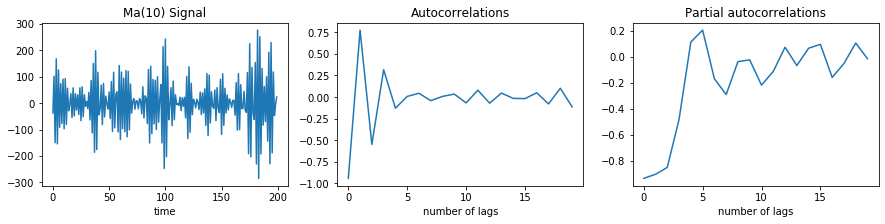

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(y_obs[0])
plt.title("Ma(10) Signal")
plt.xlabel("time")
plt.subplot(132)
plt.title("Autocorrelations")
plt.xlabel("number of lags")
plt.plot(pautocorr(y_obs,20)[0,0::4]);
plt.subplot(133)
plt.title("Partial autocorrelations")
plt.xlabel("number of lags")
plt.plot(pautocorr(y_obs,20)[0,1::4])
plt.savefig("modelchoice-Signal.svg", format="svg")
print('Thetas : ', modsimple[0])

## Setting the ABC pipeline

In [6]:
import elfi

### Wrapping priors, custom classes

We have to sample the priors corresponding to $Ma(10)$, with a sampled $\theta_{10}$ in $[1,2]$ this is the purpose of the `GlobalPrior` wrapper.
The  `DependantPrior` is just the mean of all absolute values of the $\theta_i$ for the $Ma(10)$ model.

In [7]:
class GlobalPrior(elfi.Distribution):
    def rvs(q,tq,size=1,random_state=None):
        return generate_maq_priors(q,tq,size[0],random_state)

class DependantPrior(elfi.Distribution):
    def rvs(t, size=1, random_state=None):
        return np.mean(np.abs(t), axis=1)

First stages, prior dependancies

In [8]:
tq = elfi.Prior('uniform',1,1)
t  = elfi.Prior(GlobalPrior,q,tq)
tm = elfi.Prior(DependantPrior, t)

Final stages, summary stats, simulator and distance

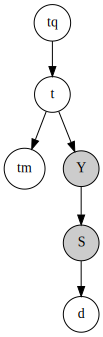

In [9]:
Y = elfi.Simulator(MAq, t, observed=y_obs)
S = elfi.Summary(pautocorr, Y, Ncov)
d = elfi.Distance('euclidean', S)
elfi.draw(d)

In [10]:
elfi.set_client('multiprocessing')
rej = elfi.Rejection(d,batch_size=batchsize,output_names=['S'])

### ABC samping

In [11]:
print('ABC sampling without rejection')
result = rej.sample(nref,quantile=1.0)

ABC sampling without rejection
Progress: |██████████████████████████████████████████████████| 100.0% Complete


# AbcRanger, posterior Parameter Estimation

In [12]:
def listvar(prefix, s):
    return [prefix+str(i) for i in range(1, s+1)]

def listvarautocorr(s):
    arr = []
    for i in range(1, s//Ncovmult+1):
        arr.append("acf"+str(i))
        arr.append("pacf"+str(i))
        arr.append("pacfq1_"+str(i))
        arr.append("pacfq2_"+str(i))
    return arr

In [13]:
import sys
sys.path.insert(0,'../build')
import pyabcranger
params = np.concatenate([result.samples['t'],result.samples['tm'][:,np.newaxis]],axis=1)

rf = pyabcranger.reftable(
    nref,
    [0],
    [q],
    listvar('t',q) + ['tm'],
    listvarautocorr(result.outputs['S'].shape[1]),
    result.outputs['S'],
    params,
    np.ones(nref)
)

In [14]:
from tqdm.notebook import tqdm

def estimparam_args(i):
    if (i == q + 1):
        l = 'm'
    else: 
        l = str(i)
    return " ".join(['-n ',str(nref),'--ntree ' + str(ntree),'--parameter t' + l,'--noob 0','--chosenscen 1'])

# Parameter estimation for all parameters thetas
postres = [pyabcranger.estimparam(rf,S.observed[0],estimparam_args(i),True,False) for i in tqdm(range(1,q+2))]

### Scoring

In [15]:
reality = np.r_[modsimple[0],[np.mean(np.abs(modsimple[0]))]]

print('Scores : ')
print('NMAE abc + mean : ',np.mean(np.abs((reality-np.mean(params,axis=0))/reality)))
print('NMAE abc + rf   : ',np.mean(np.abs((reality-np.array([postres[i].point_estimates['Expectation'] 
                                                             for i in range(q+1)]))/reality)))

Scores : 
NMAE abc + mean :  0.32427526976764925
NMAE abc + rf   :  0.2506879721937186


### Posterior distributions

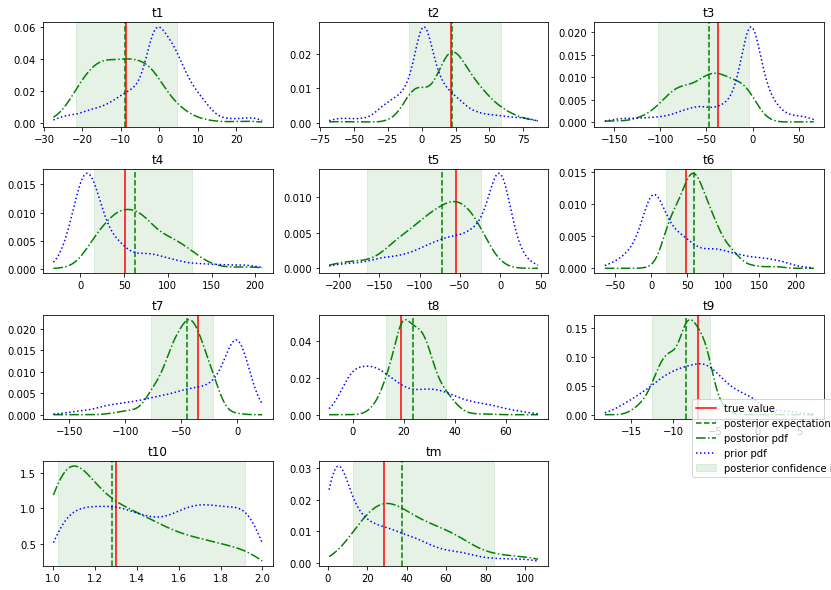

In [16]:
from scipy.stats import gaussian_kde
columns = 3
rows = ((q + 1) // columns) + 1
fig, axs = plt.subplots(rows,columns,figsize=(14, 10))
for i in range(columns * rows):
    ax = axs[i // columns, i % columns]
    if (i >= q + 1):
        ax.axis('off')
    else:
        x,y = np.asanyarray(postres[i].values_weights)[:,0],np.asanyarray(postres[i].values_weights)[:,1]
        pdfw = gaussian_kde(x,weights=y)
        pdf = gaussian_kde(x)
        xp = np.linspace(np.min(x),np.max(x),200)
        if (i == q):
            l = 'm'
        else: 
            l = str(i+1)
        ax.set_title('t' + l)
        ax.axvline(x=reality[i], color='r')
        ax.axvline(postres[i].point_estimates['Median'], color='g', linestyle = '--')
        ax.axvspan(postres[i].point_estimates['Quantile_0.05'],
                   postres[i].point_estimates['Quantile_0.95'],
                   alpha=0.1,color='g')
        ax.plot(xp,pdfw(xp),color="g",linestyle = '-.')
        ax.plot(xp,pdf(xp),color="b", linestyle = 'dotted')

fig.legend(['true value',
            'posterior expectation',
            'postorior pdf','prior pdf',
            'posterior confidence interval'],
           loc='lower right',bbox_to_anchor=(.8, 0.15, .07, .05))
fig.subplots_adjust(hspace=0.4)
plt.savefig("posterior-distrib.svg",format="svg")